In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
import json

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

In [2]:
skills = pd.read_csv("../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
w2v = json.load(open("../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [11]:
df_pred = pd.read_csv("../Data/df_pred.csv").drop("Unnamed: 0", axis=1)

In [12]:
df_pred.head()

,candidate_id,job_order,time_between,time_spent,isco_functie_niveau,education,function_id,isco_code4
0,84556,0,37,156,2.0,0.0,937.0,207.0
1,84556,1,23,116,1.0,0.0,811.0,347.0
2,84556,2,23,275,2.0,0.0,937.0,207.0
3,84556,3,1155,4,1.0,0.0,1521.0,343.0
4,84556,4,203,11,1.0,0.0,1521.0,343.0


In [13]:
career_paths = df_pred.groupby("candidate_id")

In [14]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(354, 7)

In [15]:
# Convert to 2d-arrays, getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[:,1:])

100%|██████████| 465468/465468 [00:44<00:00, 10528.73it/s]


In [16]:
# Drop careers that are longer than 100 jobs or only 1 job
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens <= 101) & (career_lens > 1)]

In [17]:
career_paths.head()

candidate_id
84556    [[0.0, 37.0, 156.0, 2.0, 0.0, 937.0, 207.0], [...
84612    [[0.0, 2537.0, 6.0, 1.0, 0.0, 1521.0, 343.0], ...
84731    [[0.0, 46.0, 23.0, 1.0, 0.0, 1521.0, 343.0], [...
85437    [[0.0, 747.0, 670.0, 1.0, 2.0, 1521.0, 343.0],...
85627    [[0.0, 140.0, 4627.0, 3.0, 0.0, 1922.0, 155.0]...
dtype: object

In [18]:
idxs = []
x = []
y = []

candidate_lens = defaultdict(int)

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, 6]
    
    if not np.isnan(label):
        candidate_lens[idx] = len(career) - 1
        
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [19]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [20]:
max_len = len(max(x, key = lambda x: len(x)))

In [21]:
del df_pred
del x

In [22]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [23]:
len(to_fill), len(y)

(265309, 265309)

In [24]:
# to_fill = to_fill[:75000]
# y = y[:75000]

In [25]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

train_indices, val_indices = idxs[training], idxs[test]
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [26]:
# Class weights
counts = np.bincount(y_train) + 1
labels_weights = 1. / counts
weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders
train_data = TensorDataset(torch.Tensor(train_indices), 
                           torch.Tensor(X_train), 
                           torch.Tensor(y_train).type(torch.LongTensor))

trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(val_indices),
                         torch.Tensor(X_val),
                         torch.Tensor(y_val).type(torch.LongTensor))

valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [33]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, skills, certs, licenses, languages,
                 w2v, candidate_lengths, max_len, static_embedding_size, position_embedding_size):
        
        super(LSTM, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.LSTMs = nn.ModuleList()
        
        for i in range(num_layers):
            input_size = self.input_size if i == 0 else hidden_size
            self.LSTMs.append(nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                      num_layers=1, batch_first=True))
        
        # Final fully-connected layer takes the LSTM output, as well as the static embeddings
        self.fc = nn.Linear(hidden_size + static_embedding_size, num_classes)
        
        # Static embeddings: skills, certificates, licenses, languages
        self.static_embedding = nn.Linear(317 + 98 + 8 + 23, static_embedding_size, bias=False)
        self.static_embedding.weight.data = torch.randn_like(self.static_embedding.weight) 
        
        # Position embeddings: regular features for each job
        self.position_embedding = nn.Linear(self.input_size, position_embedding_size, bias=False)
        self.position_embedding.weight.data = torch.randn_like(self.position_embedding.weight) 

        # Skill lookup
        self.skill_keys = set(skills.keys())
        self.skills = np.vectorize(skills.get)
        
        # Certificate lookup
        self.certs_keys = set(certs.keys())
        self.certs = np.vectorize(certs.get)
        
        # License lookup
        self.license_keys = set(licenses.keys())
        self.licenses = np.vectorize(licenses.get)
        
        # Language lookup
        self.langs_keys = set(languages.keys())
        self.langs = np.vectorize(languages.get)
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len
                
    def static_lookup(self, candidate):
        """Looks up a candidate's static features (skills, certificates)"""
         # Look up skills            
        if candidate.item() in self.skill_keys:
            skill_list = torch.Tensor(self.skills(candidate.item())).type(torch.LongTensor).to(device)
        else:
            skill_list = torch.Tensor([0] * 317).type(torch.LongTensor).to(device)

        # Look up certificates
        if candidate.item() in self.certs_keys:
            certs_list = torch.Tensor(self.certs(candidate.item())).type(torch.LongTensor).to(device)
        else:
            certs_list = torch.Tensor([0] * 98).type(torch.LongTensor).to(device)
            
        # Look up certificates
        if candidate.item() in self.license_keys:
            license_list = torch.Tensor(self.licenses(candidate.item())).type(torch.LongTensor).to(device)
        else:
            license_list = torch.Tensor([0] * 8).type(torch.LongTensor).to(device)
        
        # Look up certificates
        if candidate.item() in self.langs_keys:
            langs_list = torch.Tensor(self.langs(candidate.item())).type(torch.LongTensor).to(device)
        else:
            langs_list = torch.Tensor([0] * 23).type(torch.LongTensor).to(device)
        
            
        return skill_list, certs_list, license_list, langs_list
    
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.Tensor(cvs[0]).type(torch.LongTensor).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()
                if durations[-1] == -1: # Sometimes contains -1 --> last location > (career duration)?
                    durations.pop()
                    durations[-1] -= 1
                    # In case the last one should be ignored completely
                    if durations[-1] == 0:
                        durations.pop()

                if durations:
                    for i, duration in enumerate(durations):
                        storage.append(torch.stack([torch.Tensor(embed_values[i])] * duration, dim=0))
                else:
                    w2v_list = torch.Tensor(cvs[0]).type(torch.LongTensor).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list

    def forward(self, candidate, x):       
        outputs = []
        
        # Default width of a row (filled with 0s)
        cv_width = torch.Tensor([0] * 300).type(torch.LongTensor).to(device)
        
        candidate_cvs = []
        candidate_static = []
                
        # For each candidate in the current batch
        for c in candidate:
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]            
            
            # Get skills and certificates
            skill_list, certs_list, license_list, langs_list = self.static_lookup(c)
            
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([cv_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.Tensor([]).type(torch.LongTensor).to(device)
                
            # Combine and embed
            static_features = torch.cat([skill_list, certs_list, 
                                         license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
            # TODO: embed individually
            static_features = self.static_embedding(static_features)
            
            # Broadcast CV to the correct length
            cv_features = torch.cat([zeros, w2v_list], dim=0)
                    
            # Store result
            candidate_cvs.append(cv_features)
            candidate_static.append(static_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_cvs)).type(torch.FloatTensor).to(device)
                
        # Add features
        x = torch.cat([x, additional_features], dim=2)
        
        # Forward pass
        for i in range(self.num_layers):
            # All hidden state, last hidden state, last cell state
            output, (h_n, c_n) = self.LSTMs[i](x)
            outputs.append(output)
            x = output
            
        h_out = h_n.view(-1, self.hidden_size)
        
        static = torch.stack((candidate_static)).type(torch.FloatTensor).to(device)

        # combine with embedding
        x = torch.cat([h_out, static], dim=1)
        
        # TODO: attention ???        

        # Fully-connected
        out = self.fc(x)

        # softmax
        out = self.softmax(out)
                        
        return out

In [34]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    # Train the model
    for epoch in range(num_epochs):
        for i, (candidate, career, job) in enumerate(trainloader):
            
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs = model(candidate, career)

            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
        
        stats = test_loop(valloader, model, criterion)
        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        
        scheduler.step()
                
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            candidate, career, job = candidate.to(device), career.to(device), job.to(device)
            pred = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    # print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}\n")
    
    return acc1, acc5, acc10, acc20, test_loss

In [35]:
torch.cuda.empty_cache()

In [36]:
num_epochs = 15
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

try:            
    for learning_rate in [1e-1, 1e-2, 1e-3, 1e-4][2:]:
        for num_layers in [1, 5, 10]:
            for hidden_size in [500, 1000][1:]:

                lstm = LSTM(num_classes=num_classes,
                            input_size=num_features,
                            num_layers=num_layers,
                            hidden_size=hidden_size,
                            skills=skills, 
                            certs=certs,
                            licenses=licenses,
                            languages=languages,
                            w2v=w2v,
                            static_embedding_size=10,
                            position_embedding_size=10,
                            candidate_lengths=candidate_lens,
                            max_len=max_len)

                lstm = lstm.to(device)

                optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                print(f"Current iteration {current}/{4**3}\n- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                # Store results of current configuration
                outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                outcome["lr"] = [learning_rate] * num_epochs
                outcome["Number of layers"] = [num_layers] * num_epochs
                outcome["Nodes per layer"] = [hidden_size] * num_epochs

                full_results.append(outcome)

                current += 1
            break

        # We ignore LR for now
        break
except KeyboardInterrupt:
    pass

Current iteration 0/64
- Initial learning rate: 0.001
- Model: 

 LSTM(
  (softmax): LogSoftmax()
  (LSTMs): ModuleList(
    (0): LSTM(307, 1000, batch_first=True)
  )
  (fc): Linear(in_features=1010, out_features=354, bias=True)
  (static_embedding): Linear(in_features=446, out_features=10, bias=False)
  (position_embedding): Linear(in_features=307, out_features=10, bias=False)
) 

Epoch: 1, batch: 415/415, loss: 3.00907
Test Error:
Acc@1: 12.73%, Acc@5: 27.11%, Acc@10: 36.75%, Acc@20: 49.45% Avg loss: 4.415118

Epoch: 2, batch: 415/415, loss: 2.34761
Test Error:
Acc@1: 13.60%, Acc@5: 34.07%, Acc@10: 45.97%, Acc@20: 59.60% Avg loss: 4.145858

Epoch: 3, batch: 415/415, loss: 2.29966
Test Error:
Acc@1: 17.97%, Acc@5: 39.45%, Acc@10: 49.99%, Acc@20: 62.31% Avg loss: 3.975608

Epoch: 4, batch: 415/415, loss: 2.01493
Test Error:
Acc@1: 19.94%, Acc@5: 44.01%, Acc@10: 54.26%, Acc@20: 65.99% Avg loss: 3.829710

Epoch: 5, batch: 415/415, loss: 1.95582
Test Error:
Acc@1: 19.31%, Acc@5: 43.29%, 

In [37]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Number of layers", "Nodes per layer", "Epoch"])

In [38]:
total

Acc@1     Acc@5    Acc@10  \
lr    Number of layers Nodes per layer Epoch                                 
0.001 1                1000            1      0.127266  0.271079  0.367495   
                                       2      0.135992  0.340677  0.459708   
                                       3      0.179714  0.394501  0.499943   
                                       4      0.199427  0.440127  0.542592   
                                       5      0.193076  0.432928  0.543025   
                                       6      0.229354  0.470921  0.568222   
                                       7      0.222118  0.469300  0.567280   
                                       8      0.235913  0.481456  0.576985   
                                       9      0.228751  0.473748  0.571709   
                                       10     0.233915  0.478007  0.574875   
                                       11     0.242245  0.484301  0.579756   
                                       12     0.243658  0.486129  0.580905   
                                       13     0.245034  0.486940  0.582771   
                                       14     0.244356  0.487599  0.583016   
                                       15     0.239475  0.483981  0.579944   

                                                Acc@20  test_loss  
lr    Number of layers Nodes per layer Epoch                       
0.001 1                1000            1      0.494516   4.415118  
                                       2      0.596020   4.145858  
                                       3      0.623120   3.975608  
                                       4      0.659926   3.829710  
                                       5      0.661528   3.839830  
                                       6      0.684539   3.684549  
                                       7      0.683992   3.683796  
                                       8      0.693133   3.629322  
                                       9      0.688025   3.657660  
                                       10     0.689175   3.641386  
                                       11     0.694131   3.614019  
                                       12     0.695526   3.604912  
                                       13     0.696977   3.597675  
                                       14     0.696035   3.597362  
                                       15     0.694207   3.613881

0.23828125


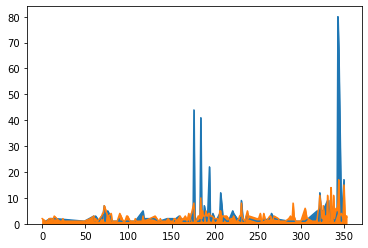

In [41]:
with torch.no_grad():
    for candidate, career, job in valloader:
        candidate, career, job = candidate.to(device), career.to(device), job.to(device)
        pred = lstm(candidate, career)
        
        print((pred.argmax(1) == job).type(torch.float).mean().item())        
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area")
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area")
        
        break

In [ ]:
emb = nn.Embedding(2, 4)
inpt = torch.Tensor([[1, 1, 1],
                     [0, 1, 0]]).type(torch.LongTensor)

emb(inpt).mean(axis=1)